# Useful functions throughout the code

In [1]:
def plot_sed(x, y, yerr):
    plt.clf()
    plt.errorbar(wavelength, flux, yerr=flux_err, c='red', ecolor='gray', capthick=2)
    plt.show()

# Libraries

In [2]:
# usual libraries ----------------------------------------------------------------------------------------------------
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import astropy.io.fits   as pf
import astropy.constants as ct
import os
import time
import scipy.interpolate as sci
import ipywidgets        as widgets
import datetime          as dt

In [3]:
# ppxf separately ----------------------------------------------------------------------------------------------------
import ppxf.miles_util   as lib  # MILES library embedded in ppxf
import ppxf.ppxf_util    as util
import ppxf              as ppxf_module
from ppxf.ppxf           import ppxf
from ppxf.ppxf_util      import log_rebin

# Dataset

In [4]:
dataset_path = './../../Catalogue/Match08_smallemlines_inputcattype.csv'
my_data      = pd.read_csv(dataset_path)

In [5]:
whan_class = my_data['WHAN_CLASS'].values.astype(str)
uv_class   = my_data['UV_CLASS_YI2011'].values.astype(str)
cataid     = my_data['CATAID'].values.astype(str)
specid     = my_data['SPECID'].values.astype(str)
s2n        = my_data['S2N'].values.astype(float)
chi2_gama  = my_data['CHI2'].values.astype(float)
redshift   = my_data['Z'].values.astype(float)

In [6]:
idx_uvup_rp = np.where((uv_class=='UV_UPTURN')*(whan_class=='Retired/Passive'))

## Plot the distributions of S/N

### Plot settings (yes, I'm lazy)

In [7]:
bins = 20
palette = ['#a6611a','#dfc27d','#80cdc1','#018571']
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.

### Histogram - S/N and $\chi^2$

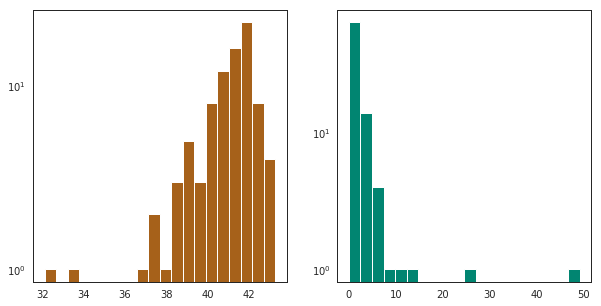

In [8]:
plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(s2n[idx_uvup_rp], bins=bins, color=palette[0])
plt.yscale('log')
plt.subplot(1,2,2)
plt.hist(chi2_gama[idx_uvup_rp], bins=bins, color=palette[3])
plt.yscale('log')
plt.show()

### Selecting top 10 objects with the best S2N

In [9]:
best_s2n_10 = np.argsort(s2n[idx_uvup_rp])[-10:-1]

In [10]:
s2n_top10 = s2n[idx_uvup_rp][best_s2n_10]    # top 10 objects given the S/N

In [11]:
chi2_top   = chi2_gama[idx_uvup_rp][best_s2n_10]
specid_top = specid[idx_uvup_rp][best_s2n_10]

# pPXF

## Configuring inputs

In [12]:
ppxf_dir     = os.path.dirname(os.path.realpath(ppxf_module.__file__))
miles_lib    = ppxf_dir+'/miles_models/Mun1.30*.fits'
seds_path   = './../../../../GAMADR3_SPECTRA/DATABASE/'
results_path = './Results/'

light_speed  = float(str(ct.c.to('km/s')).split(' ')[0])            # selecting the numerical values (must be in km/s)

In [13]:
seds_list = []
for i in specid_top: seds_list.append(i+'.fit')

In [14]:
bar = widgets.IntProgress(value=0, min=0, max=len(seds_list)+1, step=0.5, description='Running pPXF:',
                          orientation='horizontal')
display(bar)

IntProgress(value=0, description='Running pPXF:', max=10)

### pPXF plot settings

In [15]:
palette      = ['#ef8a62','#f7f7f7','#67a9cf']
transparency = 0.8
lw           = 2.

## pPXF settings

In [16]:
# Fit (V, sig, h3, h4) moments=4 for the stars; (V, sig) moments=2 for the two gas kinematic components
moments        = [4, 2, 2]
degree         = -1         # Additive Legendre polynomial degrees
mdegree        = 250        # Multiplicative Legendre polynomial degrees
regul_err      = 0.013      # Desired regularization error -- TODO: MUST CHECK WHY 0.013
tied_balmer    = True
limit_doublets = False
stellar_comp_w = [0]        # weight of the stellar component
balmer_comp_w  = [1]        # weight of the balmer emission lines
forbid_comp_w  = [2]        # weight of the forbidden lines
# wl_min         = 3540       # MILES RANGE MIN
# wl_max         = 7409       # MILES RANGE MAX
wl_min = 4350               # removing the bluest part of the spectra in order to mitigate noise effects
wl_max = 7409

In [17]:
mean_age   = ['<logAge>']
mean_metal = ['<[M/H]>']
mass2light = ['MASS2LIGHT_R']
ids        = ['CATAID']
redshifts  = ['Z']

/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     51800      1000     0.300     0.300
 comp. 1:     49984       231
 comp. 2:     49800       180
chi2/DOF: 0.01079
method = capfit ; Jac calls: 10 ; Func calls: 2604 ; Status: 2
Gas Reddening E(B-V): 5.056
Nonzero Templates:  62  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.7611       2.8   49984   231
Comp: 2       Unknown          0         7   49800   180
Comp: 2       Unknown          0       7.3   49800   180
Comp: 2       Unknown          0       4.7   49800   180
---------------------------------------------------------
Weighted <logAge> [yr]: 9.94
Weighted <[M/H]>: -0.197
Weighted <logAge> [yr]: 9.94
Weighted <[M/H]>: -0.197
M/L_r: 3.523
Current $\chi^2$: 0.0108
Ela

M/L_r: 3.523


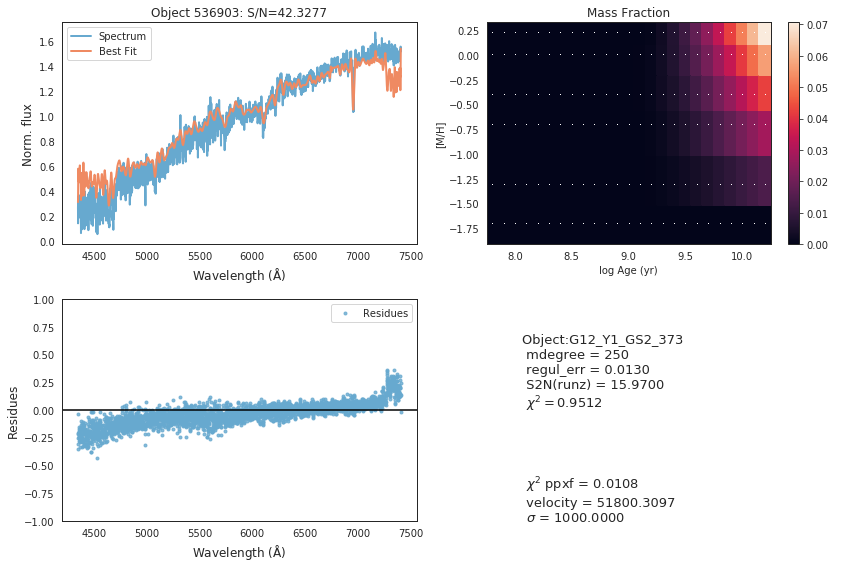

In [19]:
# for each_sed in range(len(seds_list)):
for each_sed in range(1):
    
    # settings for the progress bar widget above: does not influence in ppxf -----------------------------------------
    bar.value += each_sed/2.                                          # signal to increment the progress bar
    if each_sed<len(seds_list): 
        bar.bar_style = ""                                            # blue when in progress
    else: 
        bar.bar_style = "success"                                     # green when it finishes 
        
    # ================================================================================================================
    # flux -----------------------------------------------------------------------------------------------------------
    sed_file  = os.path.join(seds_path, seds_list[each_sed])          # link between path and files
    sed_flux  = pf.getdata(sed_file)[0]                               # opening each spectra
    sed_err   = pf.getdata(sed_file)[1]                               # opening each spectra error
    
    # wavelength -----------------------------------------------------------------------------------------------------
    sed_header = pf.open(sed_file)[0].header
    sed_wl_ini = sed_header['WMIN'] 
    sed_wl_stp = sed_header['CD1_1']
    sed_wl     = np.arange(sed_flux.size)*(sed_wl_stp)+sed_wl_ini     # sed wavelength    
#     plot_sed(sed_wl, sed_flux, sed_err)
    
    # cleaning flux and wavelength trash -----------------------------------------------------------------------------
    idx_clean       = np.where((np.logical_not(np.isnan(sed_flux)))*(sed_err>0))    # indices where NAN is present
    flux_temp       = sed_flux[idx_clean]                                           # removing NAN values from spectra
    flux_temp_err   = sed_err[idx_clean]
    wavelength_temp = sed_wl[idx_clean]    
#     plot_sed(wavelength_temp, flux_temp, flux_temp_err)
    
    # limiting the spectrum regarding the wavelength range of the library --------------------------------------------
    wl_lib_idx = (wavelength_temp>wl_min) & (wavelength_temp<wl_max)       # MILES wavelength range
    flux       = flux_temp[wl_lib_idx]
    flux_err   = flux_temp_err[wl_lib_idx]
    wavelength = wavelength_temp[wl_lib_idx]    
#     plot_sed(wavelength, flux, flux_err)    
    
    # other important parameters -------------------------------------------------------------------------------------
    redshift  = sed_header['Z']
    cataid    = sed_header['CATAID']
    fwhm_gama = 3.
    
    # ================================================================================================================
    # ppxf -----------------------------------------------------------------------------------------------------------
    vel_scale          = light_speed*np.log(wavelength[1]/wavelength[0])      # velocity scale - Eq.8 Capellari 2017
    
    ### setup templates ----------------------------------------------------------------------------------------------
    #### stellar pops ------------------------------------------------------------------------------------------------
    miles              = lib.miles(miles_lib, vel_scale, fwhm_gama)
    stellar_templates  = miles.templates.reshape(miles.templates.shape[0], -1)
    reg_dim            = miles.templates.shape[1:]
    dv                 = light_speed*(miles.log_lam_temp[0] - np.log(wavelength[0]))  # eq.(8) of Cappellari (2017)
    vel                = light_speed*np.log(1 + redshift)                             # eq.(8) of Cappellari (2017)
    start              = [vel, 180.]
    
    #### gas templates -----------------------------------------------------------------------------------------------
    wl_range_galaxy = np.array([np.min(wavelength), np.max(wavelength)])/(1 + redshift)
    gas_templates, gas_names, line_wave = util.emission_lines(miles.log_lam_temp, wl_range_galaxy, fwhm_gama, 
                                                              tie_balmer=tied_balmer, limit_doublets=limit_doublets)
    number_of_templates = stellar_templates.shape[1]
    number_of_forbidden = np.sum(["[" in a for a in gas_names])                      # forbidden lines contain "[*]"
    number_of_balmer    = len(gas_names) - number_of_forbidden
        
    component = (stellar_comp_w*number_of_templates)+(balmer_comp_w*number_of_balmer)+(forbid_comp_w
                                                                                       *number_of_forbidden)
        
    gas_component = np.array(component) > 0       # gas_component=True for gas templates
    start3        = [start, start, start]         # adopt the same starting value for the 3 components
    gas_reddening = 0 if tied_balmer else None    # If the Balmer lines are tied one should allow for gas reddening.
    
    
    #### all templates -----------------------------------------------------------------------------------------------
    all_templates = np.column_stack([stellar_templates, gas_templates])
    
    ### rebinning the spectrum so it is at the same size as the templates (or smaller) -------------------------------
    new_shape          = stellar_templates[:,0].shape
    rebinning_function = sci.interp1d(wavelength, flux)   # for the flux
    wavelength_rebin   = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_rebin         = rebinning_function(wavelength_rebin)
    
    ### rebinning the error ------------------------------------------------------------------------------------------
    rebin_func_error   = sci.interp1d(wavelength, flux_err)
    wl_rebin_error     = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_err_rebin     = rebin_func_error(wavelength_rebin)
    
    ### final galaxy spectrum and its error to be analysed -----------------------------------------------------------
    galaxy             = flux_rebin/np.median(flux_rebin)               # Normalize spectrum to avoid numerical issues
    noise              = flux_err_rebin/np.median(flux_err_rebin)       # idem
    
#     plot_sed(wavelength_rebin, galaxy, noise)
    
    # ================================================================================================================    
    ### SED FITTING WITH PPXF ----------------------------------------------------------------------------------------
    start_time = time.clock()
    sed_fit = ppxf(templates=all_templates, galaxy=galaxy, noise=noise, velscale=vel_scale, start=start3, plot=False, 
                   lam=wavelength_rebin, moments=moments, degree=degree, mdegree=mdegree, regul=1./regul_err, 
                   reg_dim=reg_dim, vsyst=dv, clean=False, component=component, gas_component=gas_component,
                   gas_reddening=gas_reddening)
    end_time = time.clock()
    
    ## output parameters -- most of them will become a dataframe at the end of the script  
    residues = (galaxy-sed_fit.bestfit)
    
    stellar_weights = sed_fit.weights[~gas_component]                         # Exclude weights of the gas templates
    stellar_weights = stellar_weights.reshape(reg_dim)/stellar_weights.sum()  # Normalized
    
    velocity = sed_fit.sol[0][0]
    sigma    = sed_fit.sol[0][1]
    
    mean_age.append(miles.mean_age_metal(stellar_weights)[0])
    mean_metal.append(miles.mean_age_metal(stellar_weights)[1])
    mass2light.append(miles.mass_to_light(stellar_weights, band="r"))
    ids.append(cataid)
    redshifts.append(redshift)
       
    print(r"Current $\chi^2$: %.4f" % (sed_fit.chi2))
    print('Elapsed time in PPXF: %.2f [min]' % ((end_time-start_time)/60))
    
    # ================================================================================================================    
    ### Saving results from the SED fitting (csv and fits) -----------------------------------------------------------
    output = {}
    output['wavelength']        = wavelength_rebin
    output['flux']              = sed_fit.galaxy
    output['best_fit']          = sed_fit.bestfit
    output['gas_bestfit']       = sed_fit.gas_bestfit
    
    output_df = pd.DataFrame(output)
    basename  = str(cataid)+'_'+str(mdegree)+'_'+str(wl_min)
    output_df.to_csv(os.path.join('./Results/', 'fit_'+basename+'.csv'), index=False)
    
    #### HDU METADATA ------------------------------------------------------------------------------------------------
    metadata              = pf.Header()
    metadata['CATAID']    = cataid
    metadata['SPECID']    = sed_header['SPECID']
    metadata['Z']         = redshift
    metadata['FIT_CODE']  = 'pPXF'
    metadata['TEMPLATES'] = 'MILES'
    metadata['COMMENT']   = 'MILES library covers the range of wavelength 3540-7409'
    metadata['WMIN']      = wl_min
    metadata['WMAX']      = wl_max
    metadata['mdegree']   = mdegree
    metadata['<logAge>']  = miles.mean_age_metal(stellar_weights)[0]
    metadata['<[M/H]>']   = miles.mean_age_metal(stellar_weights)[1]
    metadata['M2L_r']     = miles.mass_to_light(stellar_weights, band="r")
    metadata['SIGMA']     = sigma
    metadata['VELOCITY']  = velocity
    metadata['DATE']      = dt.datetime.now().strftime("%d/%m/%Y")
    metadata['TIME']      = dt.datetime.now().strftime("%H:%M:%S")

    primary_hdu = pf.PrimaryHDU(header=metadata)
    
    #### HDU DATA ----------------------------------------------------------------------------------------------------
    column01 = pf.Column(name='wavelength', format='D', array=wavelength_rebin)
    column02 = pf.Column(name='flux', format='D', array=sed_fit.galaxy)
    column03 = pf.Column(name='best_fit', format='D', array=sed_fit.bestfit)
    column04 = pf.Column(name='residues', format='D', array=residues)
    column05 = pf.Column(name='templates_weights', format='D', array=sed_fit.weights)
    
    columns = pf.ColDefs([column01, column02, column03, column04, column05])
    output_hdu = pf.BinTableHDU.from_columns(columns)
    
    #### FULL HDU INTO FITS FILE -------------------------------------------------------------------------------------
    all_hdu = pf.HDUList([primary_hdu, output_hdu])
    all_hdu.writeto(os.path.join('./Results/FitsResults/', 'fit_'+basename+'.fits'))
    
    # ================================================================================================================
    ### Saving plots -------------------------------------------------------------------------------------------------
    plt.subplots(figsize=(12,8))
    
    #### plot01 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,1)
    plt.plot(wavelength_rebin, sed_fit.galaxy, '-', color=palette[-1], linewidth=lw, label="Spectrum")
    plt.plot(wavelength_rebin, sed_fit.bestfit, '-', color=palette[0], linewidth=lw, label="Best Fit")
    plt.title("Object %s: S/N=%.4f" % (cataid, s2n_top10[each_sed]))
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Norm. flux", fontsize=12)
    
    #### plot02 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,2)
    miles.plot(stellar_weights)
    
    #### plot03 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,3)
    plt.plot(wavelength_rebin, residues, '.', color=palette[-1], linewidth=lw, label="Residues", alpha=transparency)
    plt.axhline(y=0, c='black')
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Residues", fontsize=12)
    plt.ylim([-1,1])
    
    #### plot04 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,4)
    plt.text(0.1, 0.5, "Object:{:s} \n mdegree = {:d} \n regul_err = {:.4f}\n S2N(runz) = {:.4f} \n $\chi^2 = ${:.4f}"
             .format(sed_header['SPECID'], mdegree, regul_err, sed_header['SN'], chi2_top[each_sed]), 
             fontsize=13)
    plt.text(0.1, 0.0, " \n $\chi^2$ ppxf = {:.4f} \n velocity = {:.4f} \n $\sigma$ = {:.4f}"
             .format(sed_fit.chi2, velocity, sigma), fontsize=13)
    plt.axis('off') 
    
    plt.tight_layout()
    plt.savefig(os.path.join('./Results/FitsResults/', 'gal_'+basename+'.png'), dpi=100)
    plt.show()

In [ ]:
### Saving outputs as dataframe ----------------------------------------------------------------------------------
ids        = np.array(ids)
redshifts  = np.array(redshifts)
mean_age   = np.array(mean_age)
mean_metal = np.array(mean_metal)
mass2light = np.array(mass2light)
outputs    = np.column_stack((ids, redshifts, mean_age, mean_metal, mass2light))
columns    = outputs[0,:]
outputs_dataframe = pd.DataFrame(outputs[1:,:])
outputs_dataframe.columns = columns
outputs_dataframe.to_csv('./Results/FitsResults/'+'ouputs_ppxf_'+str(mdegree)+'_'+str(wl_min)+'.csv', index=False)

In [ ]:
sed_fit.galaxy.size